In [14]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path 
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join
import datetime
import myDate
import netCDF4
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [2]:
fig_dir = Path('/home/jovyan/Figures/ECCO_GMSL/')

alongtrack_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/')
alongtrack_file_dir_randomnoise = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/')
alongtrack_file_dir_missingdata = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_missingdata/')
alongtrack_file_dir_orbiterror_1cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_orbiterror_1cm/')
alongtrack_file_dir_3errors_1cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_1cm/')
alongtrack_file_dir_orbiterror_2cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_orbiterror_2cm/')
alongtrack_file_dir_3errors_2cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/')
alongtrack_file_dir_orbiterror_3cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_orbiterror_3cm/')
alongtrack_file_dir_3errors_3cm = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_3cm/')

grids_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output/')
grids_file_dir_randomnoise = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_randomnoise/')
grids_file_dir_missingdata = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_missingdata/')
grids_file_dir_orbiterror_1cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_1cm/')
grids_file_dir_3errors_1cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_1cm/')
grids_file_dir_orbiterror_2cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_2cm/')
grids_file_dir_3errors_2cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/')
grids_file_dir_orbiterror_3cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_orbiterror_3cm/')
grids_file_dir_3errors_3cm = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_3cm/')

beckley_dailyfile_dir = Path('/home/jovyan/Data/ECCO_GMSL/Beckley_dailyfiles/')
beckley_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/Beckley/')

main_dir = Path('/home/jovyan/ECCO_GMSL/')
output_dir = Path('/home/jovyan/Data/ECCO_GMSL/GMSL/')

In [ ]:
lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.pyplot as plt
    import numpy
    import cartopy
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both', which='major', labelsize=16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(numpy.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3])+latstep,latstep))
    return ax, gl

In [4]:
ECCO_SSH_all_nosicapplied=xr.open_dataarray(output_dir / ('ECCO_SSH_19922017_10days_nosicapplied.nc'))
ECCO_SSH_all_nosicapplied

<xarray.DataArray (time: 924, latitude: 360, longitude: 720)>
[239500800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

In [ ]:
ECCO_SSH_all=xr.open_dataarray(output_dir / ('ECCO_SSH_19922017_10days_sicapplied.nc'))
ECCO_SSH_all

In [11]:
result = ECCO_SSH_all.polyfit(dim = "time", skipna=True, deg = 1)
trend_ECCO = result.polyfit_coefficients.sel(degree=1).values
result

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [16]:
result = ECCO_SSH_all_nosicapplied.polyfit(dim = "time", skipna=True, deg = 1)
trend_ECCO_nosicapplied = result.polyfit_coefficients.sel(degree=1).values

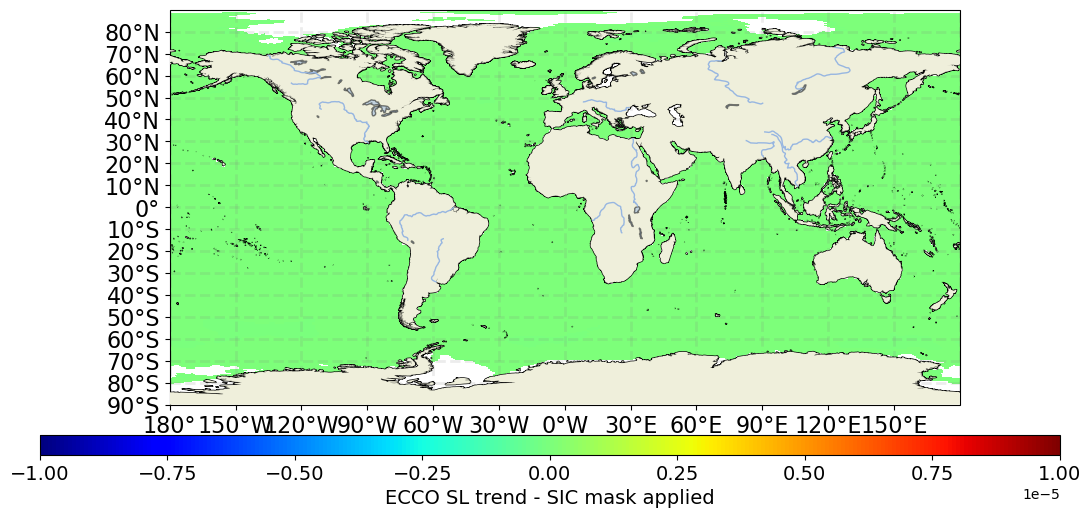

In [25]:
fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.jet
palette.set_bad('w',1.0)
pp = plt.pcolormesh(result.longitude,result.latitude,a*100,cmap=palette,vmin=-0.00001,vmax=0.00001,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('ECCO SL trend - SIC mask applied',fontsize=14)
h.ax.tick_params(labelsize=14)

# fig = plt.figure(figsize=(15,5))
# data_proj = cartopy.crs.PlateCarree(central_longitude=0)
# map_proj = cartopy.crs.PlateCarree(central_longitude=0)
# ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
# palette=plt.cm.jet
# palette.set_bad('w',1.0)
# pp = plt.pcolormesh(result.longitude,result.latitude,trend_ECCO_nosicapplied*100,cmap=palette,vmin=-20,vmax=20,transform=data_proj) 
# plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
# h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
# h.set_label('ECCO SL trend - No SIC mask applied',fontsize=14)
# h.ax.tick_params(labelsize=14)